<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/exp10_new_fashion_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
# 10-14.프로젝트 : CIFAR-10 이미지 생성하기

**STEP 1. 작업 환경 구성하기**

In [97]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

**STEP 2. 데이터셋 구성하기**

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있다.

In [98]:
# 필요한 라이브러리 모두 import

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.7.0


In [99]:
# import tensorflow as tf

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [100]:
# 이번 step에서는 (32, 32, 3)이다.
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())


max pixel: 255
min pixel: 0


In [101]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [102]:
train_x.shape

(50000, 32, 32, 3)

5만장의 이미지가 들어가있고, 사이즈는 (32x32) RGB 컬러 이미지이다.

In [103]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [104]:
# 추가한 내용
# 정규화된 데이터를 RBG값을 가진 데이터로 변환하기 위해서 함수를 만든다.

def color_normalize(train):
  return (127.5 * train) + 127.5

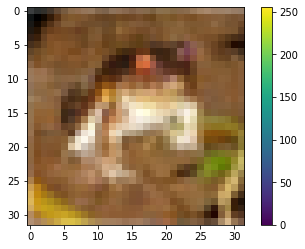

In [105]:
import matplotlib.pyplot as plt

plt.imshow(color_normalize(train_x[0]).astype(np.int32).reshape(32, 32, 3))
plt.colorbar()
plt.show()

In [106]:
# 현재 형체는 뭔지 알수가 없다. 그래서 10개 정도를 띄워서 확인을 해보고자 한다.

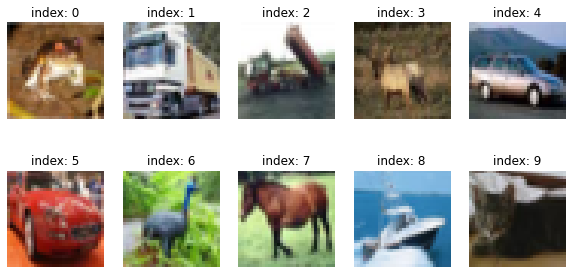

In [107]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(color_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [108]:
# 확인을 해보니 차와 말, 선박 등 fashion mnist와는 다르게 여러 물건들이 들어가 있다.

In [109]:
BUFFER_SIZE = 50000 # 전체 데이터를 섞기 위해 50,000으로 설정 (같거나 크게 설정하는 것이 좋다!)
BATCH_SIZE = 256

In [110]:
#  배치 크기는 모델 성능과 훈련 시간에 큰 영향을 미칠 수 있다. 작은 배치(2 ~32) 까지 사용하는 것이 바람직하다.
# 큰 배치 크기는 일반화 성능에 영향을 미치지 않고 훈련 시간을 매우 단축
# 여기서는 데이터 사이즈가 크기 때문에 훈련 시간단축을 위해서 256을 사용!

In [111]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

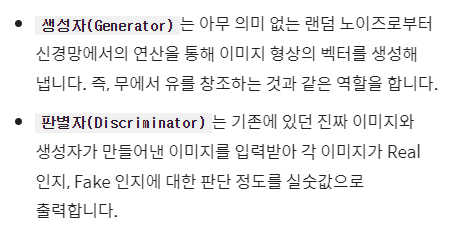

STEP 3. 생성자 모델 구현하기

In [112]:
# 모델 구현

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [113]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 128)       

In [114]:
noise = tf.random.normal([1, 100])

In [115]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

(32, 32, 3)이 제대로 생성됨. (32x32) RGB 이미지

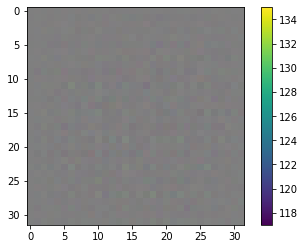

In [116]:
plt.imshow(color_normalize(generated_image[0].numpy()).astype(np.int32)) 
plt.colorbar()
plt.show()

In [117]:
# 값이 -1 ~ +1 사이에서 제대로 생성 되었고, 
# 오른쪽 scale bar는 Red color를 제외한 모든 색상이 나옴
# 생성된 랜덤 이지미가 생성자 출력 규격에 잘 맞았다.

**STEP 4. 판별자 모델 구현하기**

(32, 3, 3)의 이미지를 입력으로 받아 1dim을 판별결과로 출력하는 판별자 모델 구현 함수를 작성

위 STEP2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결괏값을 확인해 보자

In [118]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [119]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [120]:
# 가짜 이미지를 판별자에 입력!
# 텐서플로우의 텐서 형태로 출력이 됨, 이 값 또한 아직은 아무런 의미가 없는 값 일것!
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00325455]], dtype=float32)>

STEP 5. 손실함수와 최적화 함수 구현하기



*   생성자와 판별자의 손실함수를 구현항목 추가
*   판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현

*   생성자와 판별자를 최적화하는 optimizer를 정의






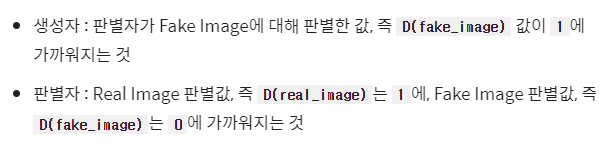

In [121]:
# tf.keras안에 losses 라이브러리 안에 교차 엔트로피 함수가 있는데, BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는
# 인풋값이 0~1사이에 분포하는 확률값이라고 가정
#from_logits를 True로 설정해주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid함수를 사용해 
# 0 ~ 1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [122]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [123]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는것도 GAN의 학습에서 중요하다.

주의할 것은 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은것이 아니다.

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘다 0.5에 가까워지는 것이 이상적이다.

fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻.

In [124]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [125]:
# 최적화 함수(optimizer)를 설정하여야 하는데, Adam 기법을 활용한다.
# 여라가지 SGD, NAG, Adagrad, RMSProp 등이 있지만, 정확도와 보폭 크기가 적절하여 성능이 가장 좋아 현재 범용적으로 사용되고 있다.

generator_optimizer = tf.keras.optimizers.Adam(1e-4) # learning rate는 0.0001로 설정되어 있는데, 적절한 값을 찾아서 바꾸어주는 것이 좋다.
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [126]:
# 샘플은 한 번에 16장을 생성하도록 한다.
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 process를 확인할수 있다. 고정된 seed 노이즈를 만들어 두어야 한다.

# 즉, 100차원의 노이즈를 총 16개, (16,100) 형상의 벡터를 만들어 두도록 한다.

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [127]:
@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용됨.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

**STEP 6. 훈련과정 상세 기능 구현하기**

1개 미니 배치의 훈련과정을 처리하는 train_step()함수를 구현

16개의 고정된 seed를 입력으로 하여 훈련 과정동안 생성한 이미지를 시각화하는 generate_and_save_images()함수를 구현

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [128]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

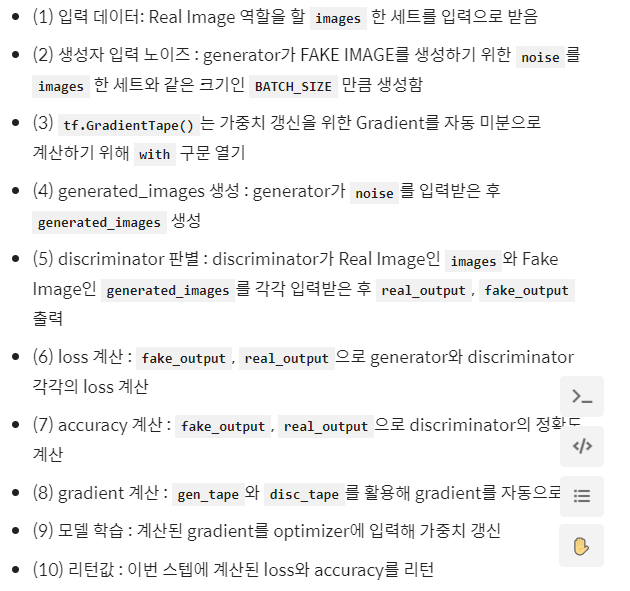

In [129]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(color_normalize(predictions[i,:,:,:].numpy()).astype(np.int32))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [130]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정.

def draw_train_history(history, epoch):
    # loss history에 대한 요약!
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # accuracy history 요약!  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [131]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

학습 시작

In [132]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [133]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

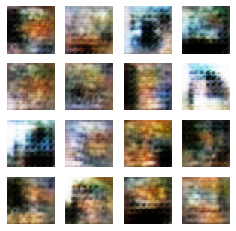

Time for training : 1490 sec


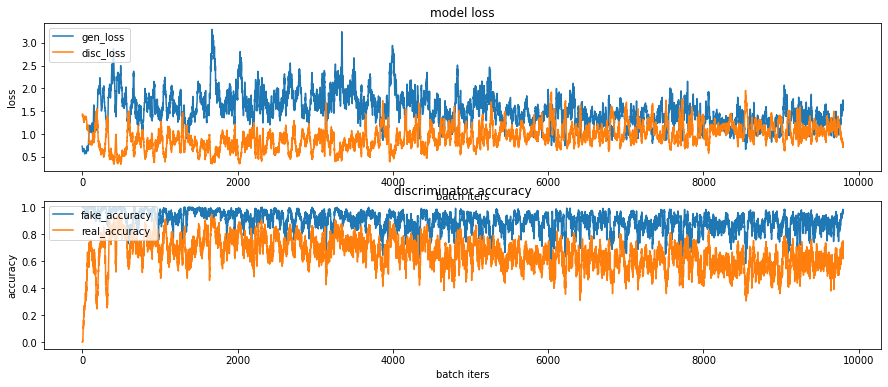

CPU times: user 24min 59s, sys: 14.2 s, total: 25min 13s
Wall time: 24min 51s


In [134]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인.

**STEP8. GAN 훈련 과정 개선하고 시각화 해보기**

In [135]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1322523 Feb 15 05:57 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


첫번째 러닝 결과

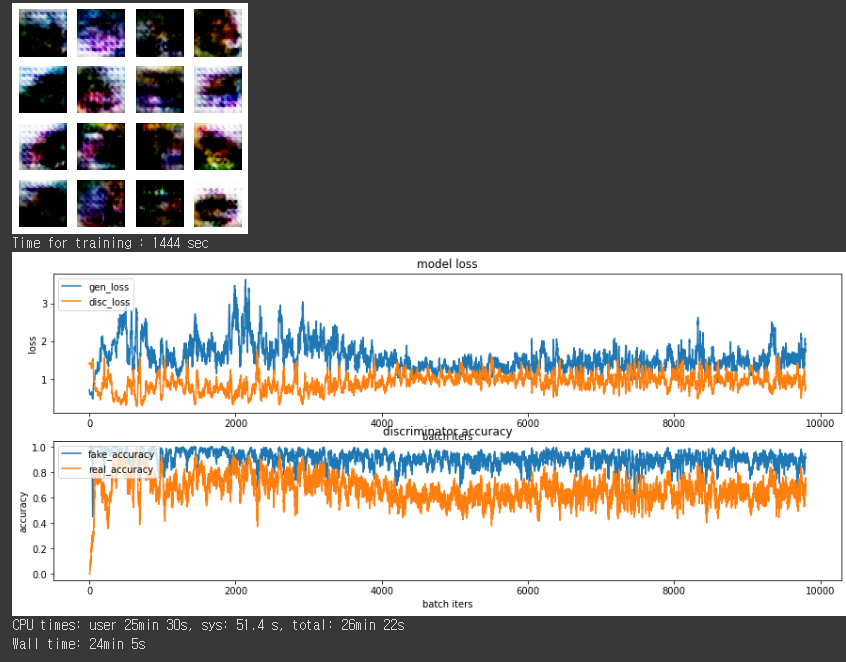

보다시피 학습한 데이터로는 형체를 알아 볼수도 없을뿐더러, Loss와 accuracy 전부 1을 상회하는 결과가 나왔다.

둘의 값이 0.5에 수렴하여야 이상적이라고 할 수 있는데 말이다.

분명 뭔가가 잘못되었다 생각하여 전처리 과정으로 돌아가서 다시 수정하여 런을 시도 해보았다.

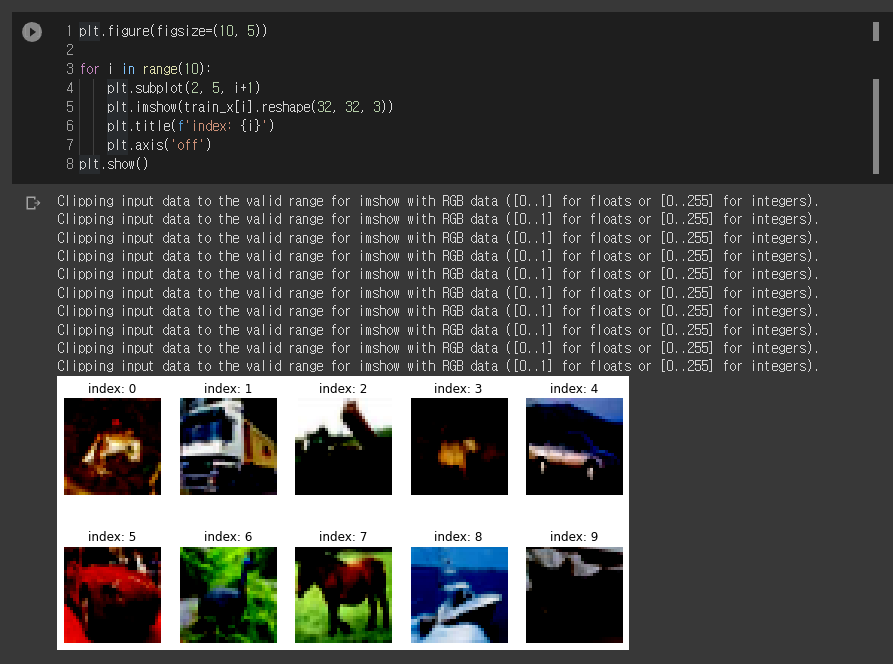

아래의 cifar-100의 이미지와의 차이점이 보였는데, 컬러화 되었더라고 하더라도 전반적으로 해상도가 낮고 문제는 검은 배경화 되어서 원래의 dataset과는 왜곡된 경향성을 보여주었다.

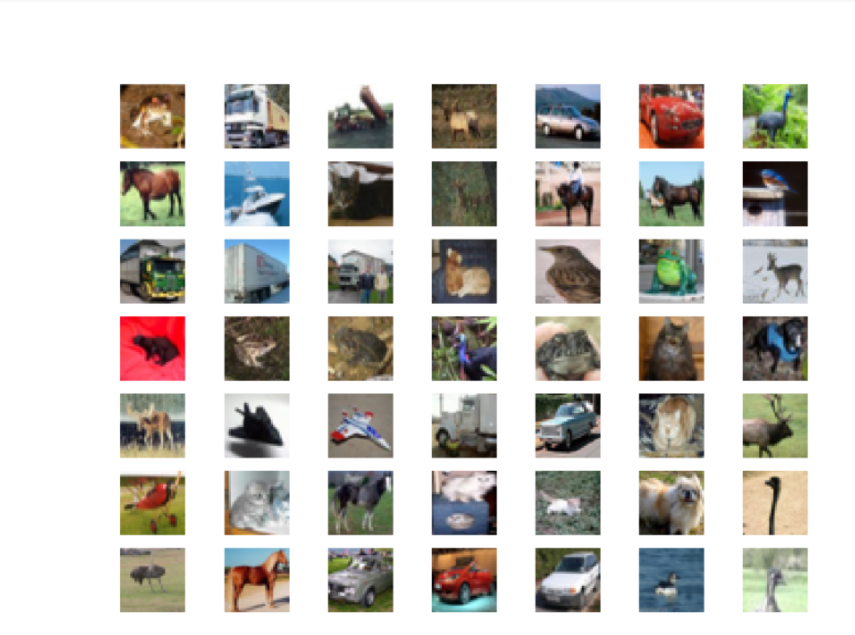

원래의 실습에서 흑백 이미지를 전처리과정에서의 보정이 필요해 보였다.

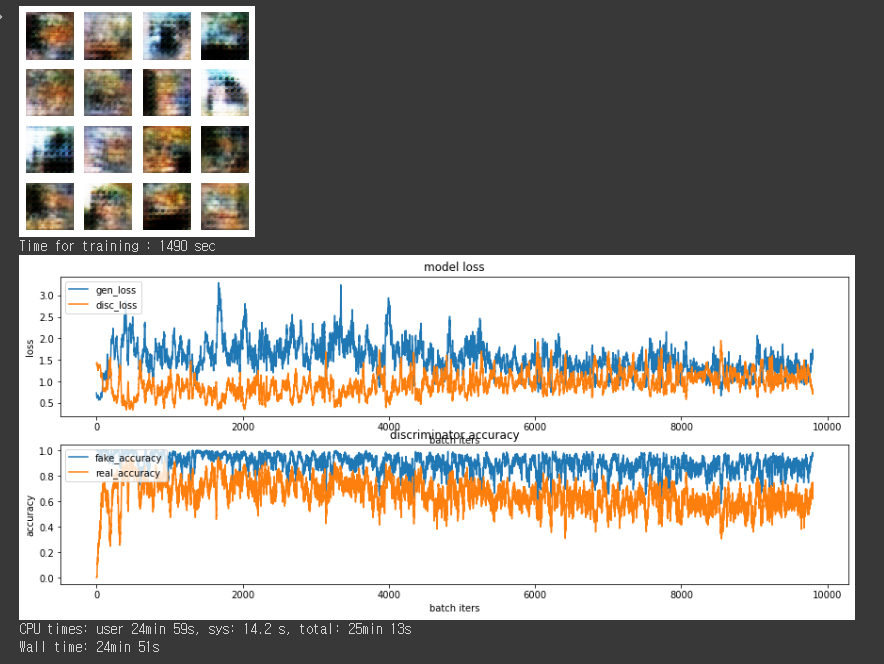

전반적으로 검은색이던 컬러가 화이트톤으로 개선되었으나, loss와 accuracy는 높게 나오고 이미지를 보아도 어떠한 형태의 객체인지 알수 업을 정도의 수준이었다.

In [136]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif

-rw-r--r-- 1 root root 1322523 Feb 15 06:08 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif


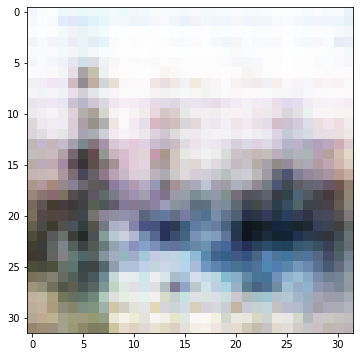

In [137]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것이다.

전반적으로 고려해야 할 부분들이 있다.

우선은 Epoch가 좀더 많아야 하지 않을까? 라는 생각과 함께 Adam optimizer에서 learning rate는 3e-4에서 best라는 관련 review 자료를 보게 되었다.

https://www.jeremyjordan.me/nn-learning-rate/



우선적으로는 Epochs를 100으로 상향하고, learning rate를 3e-4로 설정하여 학습을 추가적으로 진행해보았다.

In [138]:
save_every = 5
EPOCHS = 100 # 에포크 100으로 설정!

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [139]:
generator_optimizer = tf.keras.optimizers.Adam(3e-4) # learning rate는 0.0001로 설정되어 있는데, Adam에서 적절한 값인 3e-4로 바꾸어줌
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4) 

In [140]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

In [141]:
# 의미없는 코드 : gif 생성되는지 확인한 코드

# anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#     filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
#     filenames = sorted(filenames)
#     last = -1
#     for i, filename in enumerate(filenames):
#         frame = 2*(i**0.5)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)

# !ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif

-rw-r--r-- 1 root root 1322523 Feb 15 06:31 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan3.gif


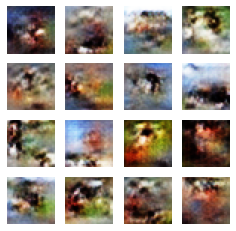

Time for training : 3036 sec


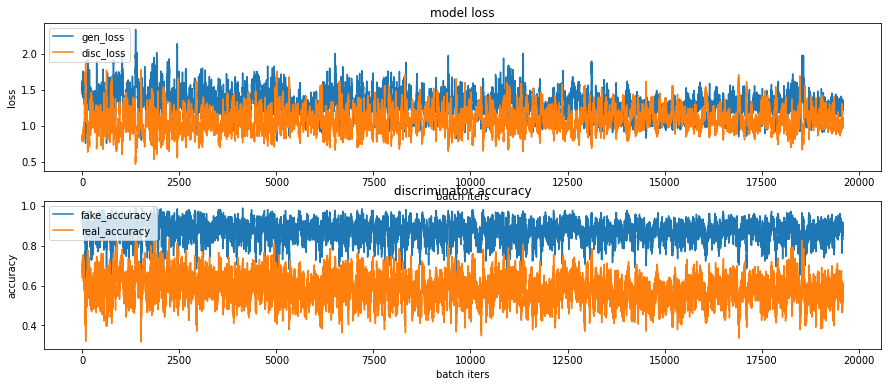

CPU times: user 50min 19s, sys: 35.1 s, total: 50min 54s
Wall time: 50min 37s


In [142]:
%%time
train(train_dataset, EPOCHS, save_every)

In [143]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved.gif

-rw-r--r-- 1 root root 1810699 Feb 15 07:26 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved.gif


그래프로 시각화 하여서 보았을때 전반적으로 accuracy 평균값 자체가 0.5를 향해 하향하고 있었고, loss 값 또한 많이 준 것을 확인할수 있었다.

하지만, 역시 육안으로 이미지를 식별하기에는 부족해 보였다.

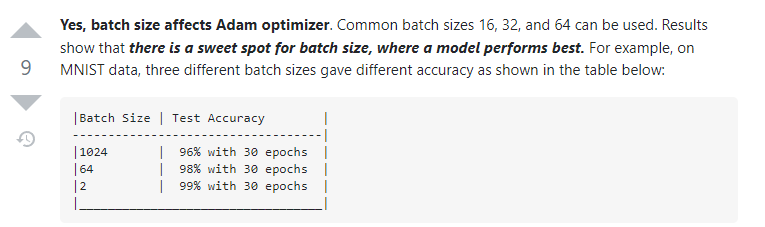

https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer

Batch size가 Adam optimizer에 영향을 준다는 글이 있었는데, 역시 reference로 논문이 달린것을 보며 신빙성 있는 자료라고 느꼈다. Batch size가 하나의 소그룹에 속하는 데이터수라서 단순히 값을 크게하면 러닝 타임을 짧게 조절하는 의미로만 볼것이 아니라 학습 시간이 많이 걸리게 값을 작게 하더라도 sharp minima로 수렴할 가능성을 최대한 낮추고, generalization 성능을 높이는 것이 좋을꺼 같았다.

(256 -> 64)시간은 소폭 상승하리라 본다. 

In [145]:
BATCH_SIZE = 64 # batch size 256 -> 64

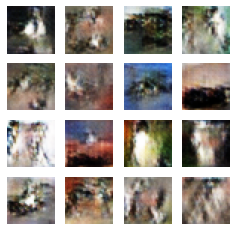

Time for training : 3033 sec


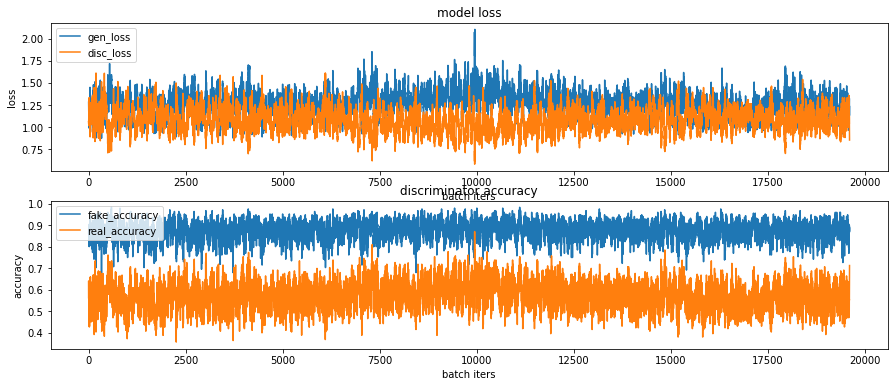

In [147]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 100 

train(train_dataset, EPOCHS, save_every)

In [148]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved2.gif

-rw-r--r-- 1 root root 1777828 Feb 15 08:56 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_improved2.gif


In [149]:
BATCH_SIZE = 32 # batch size 64 -> 32

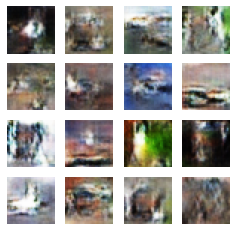

Epoch 11 | iter 101
Time for epoch 11 : 15 sec


In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 200 

train(train_dataset, EPOCHS, save_every)

EPOCHS = 200으로 설정하고 batch_size = 32로 하던도중 Colab 연결이 끊겼다. (Max Time으로 인해서..)

Colab pro 결제후 다시 진행..